In [55]:
%reload_ext autoreload
%autoreload 2

import torch
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.independent import Independent

import time

import matplotlib.pyplot as plt

from approxpost import NormalizingFlow, DiagonalGaussian, FullRankGaussian

In [56]:
torch.manual_seed(42)
n = 20
d = 20
X_no_intercept = torch.randn(n, d - 1)
X = torch.hstack([X_no_intercept, torch.ones(n, 1)])
w = torch.randn(1, d) * 2
σ = 3
y = X @ w.T + torch.randn(n, 1) * σ

In [57]:
xs = torch.linspace(-15, 15, 50)
ys = torch.linspace(-15, 15, 50)
xxs, yys = torch.meshgrid(xs, ys)
xxsyys = torch.hstack([xxs.reshape(-1, 1), yys.reshape(-1, 1)])

## Closed-form posterior inference

In [58]:
w0 = torch.zeros((d, 1))
V0 = torch.eye(d) * 100
V0_inv = torch.eye(d) / 100
VN = (σ ** 2) * torch.linalg.inv((σ ** 2 * V0_inv + X.T @ X))
wN = VN @ V0_inv @ w0 + (1 / σ ** 2) * VN @ X.T @ y

In [59]:
def shift(index):
    if index == 10:
        return 1
    else:
        return index + 1

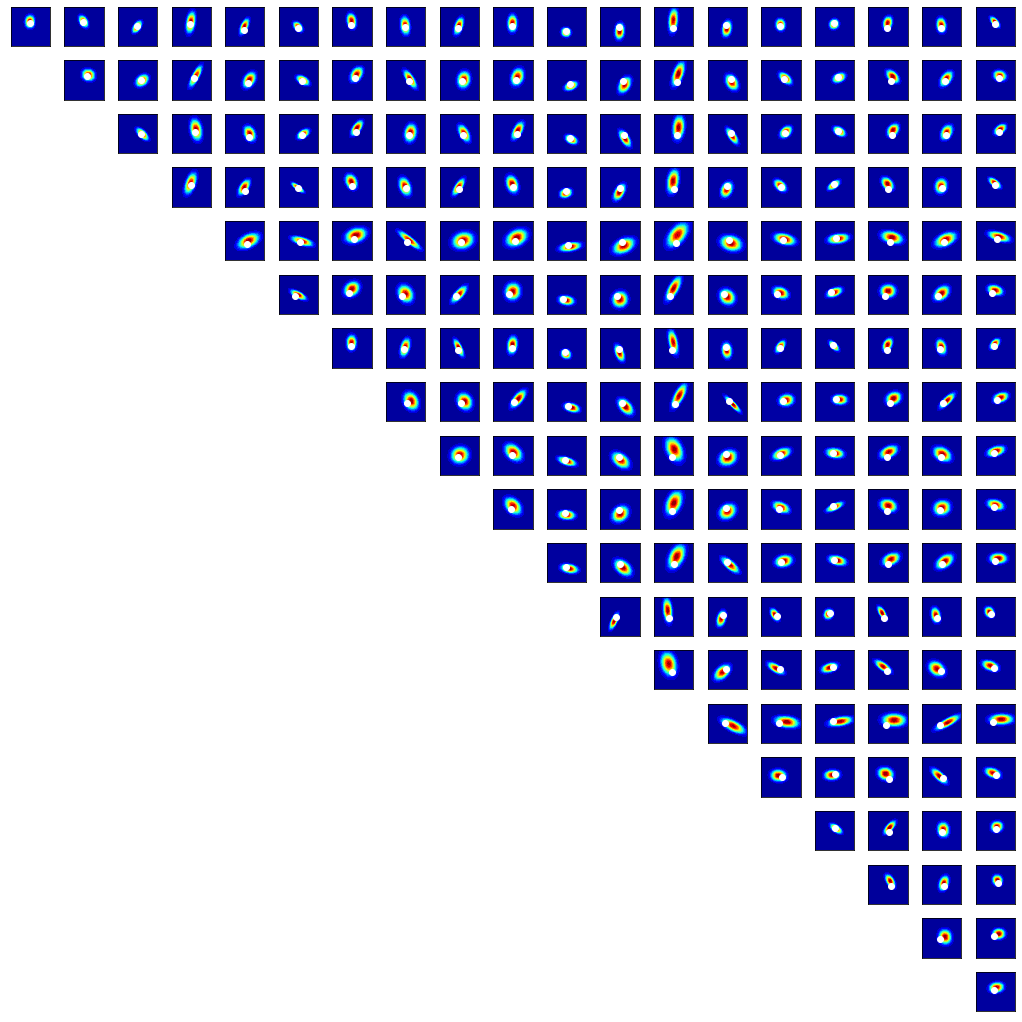

In [60]:
fig = plt.figure(figsize=(15, 15), )
for i in range(1, d+1):
    for j in range(1, d+1):
        if i < j:
            
            fig.add_subplot(d, d, (i-1) * d + j)
            
            marginal = MultivariateNormal(
                loc=torch.Tensor([wN[i-1], wN[j-1]]), 
                covariance_matrix=
                    torch.round(
                        torch.Tensor([[VN[i-1, i-1], VN[i-1, j-1]], [VN[j-1, i-1], VN[j-1, j-1]]]), 
                    decimals=1)  # need to do rounding due to weird numerical imprecisions ??
            )
            
            ps = marginal.log_prob(xxsyys).view(50, 50) #+ marginal2.log_prob(xxsyys).view(50, 50)
            
            plt.contourf(xxs, yys, torch.exp(ps), levels=20, cmap="jet")
            
            plt.scatter([w[0][i-1]], [w[0][j-1]], color="white")
            
            plt.xlim(-15, 15)
            plt.ylim(-15, 15)
            #plt.axis("off")
            plt.xticks([])
            plt.yticks([])
            plt.gca().set_aspect("equal")
        
plt.tight_layout()
        
plt.show()

In [7]:
# from torch.distributions import constraints

In [18]:
# constraints.positive_definite.check(torch.tensor([[3.5670, 0.2076],
#         [0.2076, 6.8822]]))

## Variational inference with normalizing flows

In [17]:
prior = MultivariateNormal(loc=torch.zeros(d, ), covariance_matrix=torch.eye(d) * 100)

In [18]:
def log_unnormalized_posterior(w):
    model = Independent(Normal(loc=(w @ X.T), scale=σ), 1)
    return prior.log_prob(w) + model.log_prob(y.view(1, -1))

In [28]:
# q = NormalizingFlow(D=d)
q = FullRankGaussian(D=d)
opt = optim.Adam(q.parameters(), lr=1e-2)

start = time.perf_counter()

samples_kls = []

for i in range(1, 10001):
    
    samples_from_q_K, log_probs = q.sample(n=1000)
    sample_kl = (log_probs - log_unnormalized_posterior(samples_from_q_K)).mean()  # monte-carlo estimate of the kl-divergence
    samples_kls.append(float(sample_kl))
    
    opt.zero_grad()
    sample_kl.backward(retain_graph=True)  # I honestly don't understand why retain_graph=True is needed ...
    opt.step()

    if i % 100 == 0:
        
        print(i, float(sample_kl))
            
end = time.perf_counter()
end - start

100 108.53363800048828
200 93.04269409179688
300 89.20552825927734
400 87.77737426757812
500 87.13026428222656
600 86.83717346191406
700 86.62261962890625
800 86.46720123291016
900 86.4814682006836
1000 86.49150848388672
1100 86.42800903320312
1200 86.41951751708984
1300 86.31932830810547
1400 86.27918243408203
1500 86.29084014892578
1600 86.1761245727539
1700 86.1612319946289
1800 86.12976837158203
1900 86.08206176757812
2000 86.06280517578125
2100 85.96542358398438
2200 85.99371337890625
2300 85.96466827392578
2400 85.95850372314453
2500 85.9332046508789
2600 85.9727783203125
2700 85.90292358398438
2800 85.87740325927734
2900 85.84919738769531
3000 85.82295227050781
3100 85.82295989990234
3200 85.82098388671875
3300 85.81124877929688
3400 85.78826141357422
3500 85.79454803466797
3600 85.7692642211914
3700 85.76781463623047
3800 85.75110626220703
3900 85.74601745605469
4000 85.73644256591797
4100 85.73579406738281
4200 85.7439956665039
4300 85.73384094238281
4400 85.73458099365234
450

16.770836542000012

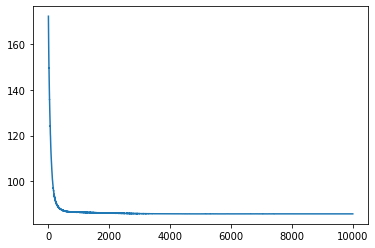

In [29]:
plt.plot(samples_kls)
plt.show()

In [30]:
with torch.no_grad():
    z_K, _ = q.sample(n=1000)

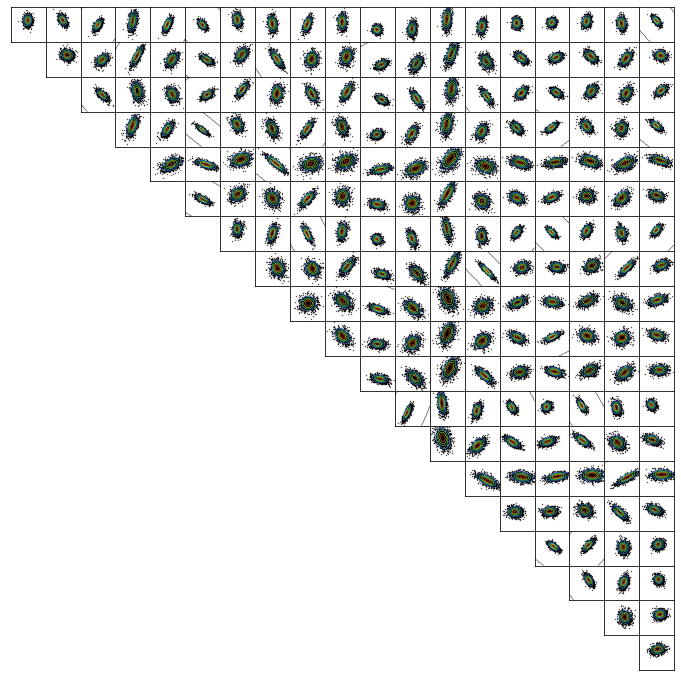

In [31]:
fig = plt.figure(figsize=(10, 10), )
for i in range(1, d+1):
    for j in range(1, d+1):
        if i < j:
            
            fig.add_subplot(d, d, (i-1) * d + j)
            
            marginal = MultivariateNormal(
                loc=torch.Tensor([wN[i-1], wN[j-1]]), 
                covariance_matrix=
                    torch.round(
                        torch.Tensor([[VN[i-1, i-1], VN[i-1, j-1]], [VN[j-1, i-1], VN[j-1, j-1]]]), 
                    decimals=2)  # need to do rounding due to weird numerical imprecisions
            )
            
            ps = marginal.log_prob(xxsyys).view(50, 50) #+ marginal2.log_prob(xxsyys).view(50, 50)
            
            # plt.scatter([w[0][i-1]], [w[0][j-1]], color="white")
            
            plt.scatter(z_K[:,i-1], z_K[:,j-1], s=0.1, alpha=1, color="black")
            
            plt.contour(xxs, yys, torch.exp(ps), levels=5, cmap="turbo", linewidths=0.5)
            
            plt.xlim(-15, 15)
            plt.ylim(-15, 15)
            #plt.axis("off") 
            plt.xticks([])
            plt.yticks([])
            plt.gca().set_aspect("equal")
        
plt.tight_layout() 
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig("10d_bayes_logreg_vi.png", dpi=500)

In [61]:
key_point_1 = torch.Tensor([-5, -5, -5, -5, -5, -5, -5, -5, -5, -5]).view(1, -1)
key_point_2 = torch.Tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5]).view(1, -1)
key_point_3 = torch.Tensor([-5, 5, -5, 5, -5, 5, -5, 5, -5, 5]).view(1, -1)

In [62]:
key_point_1[:, [3, 5]]

tensor([[-5., -5.]])

In [63]:
def unnormalized_density_two_dims(x, dim1, dim2):
    return torch.exp(- torch.linalg.vector_norm(x - key_point_1[:, [dim1, dim2]], dim=1)) +\
           torch.exp(- torch.linalg.vector_norm(x - key_point_2[:, [dim1, dim2]], dim=1)) +\
           torch.exp(- torch.linalg.vector_norm(x - key_point_3[:, [dim1, dim2]], dim=1))

In [64]:
def unnormalized_density(x):
    return torch.exp(- torch.linalg.vector_norm(x - key_point_1, dim=1)) +\
           torch.exp(- torch.linalg.vector_norm(x - key_point_2, dim=1)) +\
           torch.exp(- torch.linalg.vector_norm(x - key_point_3, dim=1))

In [65]:
def log_unnormalized_density_two_dims(x, dim1, dim2):
    return torch.logsumexp(torch.hstack([
        - torch.linalg.vector_norm(x - key_point_1[:, [dim1, dim2]], dim=1).view(-1, 1),
        - torch.linalg.vector_norm(x - key_point_2[:, [dim1, dim2]], dim=1).view(-1, 1),
        - torch.linalg.vector_norm(x - key_point_3[:, [dim1, dim2]], dim=1).view(-1, 1)
    ]), dim=1)

In [66]:
def log_unnormalized_density(x):
    return torch.logsumexp(torch.hstack([
        - torch.linalg.vector_norm(x - key_point_1, dim=1).view(-1, 1),
        - torch.linalg.vector_norm(x - key_point_2, dim=1).view(-1, 1),
        - torch.linalg.vector_norm(x - key_point_3, dim=1).view(-1, 1)
    ]), dim=1)

In [67]:
xs = torch.linspace(-15, 15, 50)
ys = torch.linspace(-15, 15, 50)
xxs, yys = torch.meshgrid(xs, ys)
xxsyys = torch.hstack([xxs.reshape(-1, 1), yys.reshape(-1, 1)])

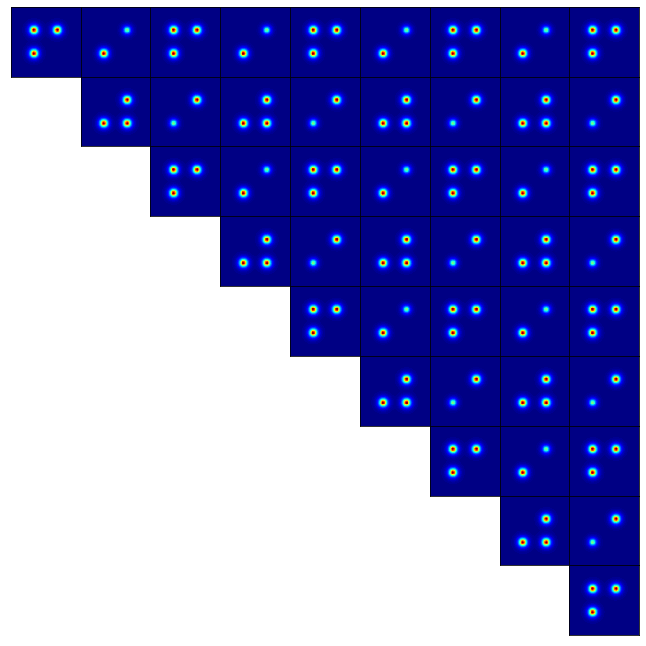

In [68]:
fig = plt.figure(figsize=(10, 10), )
for i in range(1, 10+1):
    for j in range(1, 10+1):
        if i < j:
            
            fig.add_subplot(10, 10, (i-1) * 10 + j)
            
            ps = log_unnormalized_density_two_dims(xxsyys, i-1, j-1).view(50, 50) #+ marginal2.log_prob(xxsyys).view(50, 50)
            
            # plt.scatter([w[0][i-1]], [w[0][j-1]], color="white")
            
            #plt.scatter(z_K[:,i-1], z_K[:,j-1], s=0.1, alpha=1, color="black")
            
            plt.contourf(xxs, yys, torch.exp(ps), levels=100, cmap="jet")
            
            plt.xlim(-15, 15)
            plt.ylim(-15, 15)
            #plt.axis("off") 
            plt.xticks([])
            plt.yticks([])
            plt.gca().set_aspect("equal")
        
plt.tight_layout() 
fig.subplots_adjust(wspace=0, hspace=0)
        
plt.savefig("10d_trimodal_true_density.png", dpi=100, bbox_inches='tight')

In [599]:
class GMM2(torch.nn.Module):
    
    def __init__(self, D, K):
        super().__init__()
        self.K = K
        self.D = D
        self.pre_π = torch.zeros(K, )
        self.μs = torch.nn.Parameter(torch.zeros(K, D))
        self.pre_σs = torch.nn.Parameter(torch.ones(K, D) * -1)  # small sd, otherwise might start in region with too low U, leading to nan
        
    def sample(self, n):
        
        self.comp = tdist.Independent(tdist.Normal(self.μs, torch.exp(self.pre_σs)), 1)
        self.cat = tdist.Categorical(logits=self.pre_π)
        # mixer = F.gumbel_softmax(self.pre_π.repeat(n, 1), tau=0.5, hard=True)  # (n, k)
        # sampling
        
        #mixer = F.gumbel_softmax(self.pre_π.repeat(n, 1).detach(), tau=self.tau, hard=True)  # (n, k)
        indices = self.cat.sample((n, ))  # (n,)
        samples_from_each_gaussian = self.comp.rsample(sample_shape=(n, ))  # (n, k, d)
        samples = samples_from_each_gaussian.gather(1, indices.view(-1, 1, 1).repeat(1, 1, self.D)).squeeze()
        
        # log prob computation
        return samples
        
    def log_prob(self, samples):
        
        n = samples.shape[0]
        
        self.comp = tdist.Independent(tdist.Normal(self.μs, torch.exp(self.pre_σs)), 1)
        log_π = torch.nn.functional.log_softmax(self.pre_π, dim=0).view(1, -1)  # (1, k)
        log_prob_under_each_gaussian = self.comp.log_prob(samples.view(n, 1, -1))  # (n, k)    
        log_prob_per_sample = torch.logsumexp(log_π + log_prob_under_each_gaussian, dim=1)
        
        return log_prob_per_sample

In [603]:
estimated_dist = GMM2(D=2, K=100)
samples = estimated_dist.sample(n=64)
estimated_dist.log_prob(samples)

tensor([-0.9060, -1.3770, -0.2452, -0.4188, -3.4542,  0.0455,  0.1406, -0.7448,
        -0.8620, -0.1999, -1.5314, -0.9410, -1.1897,  0.1007, -0.7768, -1.0076,
         0.1181, -0.0981, -0.1081, -0.3718, -0.6511, -0.0936,  0.0800, -0.8551,
        -1.0957, -0.1886,  0.0660,  0.0602,  0.1426, -0.9096, -0.3593, -1.2110,
        -1.1676, -0.4832, -0.1731, -2.2155,  0.1205,  0.1361, -0.0896, -0.3322,
        -0.6021, -2.5181,  0.0252, -2.5752, -0.2099, -0.4896, -0.7766, -0.1099,
        -0.6224, -0.0522,  0.1481, -0.4133,  0.0158,  0.1289, -1.1874, -2.4140,
        -1.0521, -0.1855, -2.6539, -0.0973,  0.1576, -2.0416, -1.8821, -0.7637],
       grad_fn=<LogsumexpBackward0>)

In [604]:
true_samples.shape

torch.Size([10000, 2])

In [605]:
opt = optim.Adam(estimated_dist.parameters(), lr=1e-1)
for i in range(1, 10001):
    
    score = - estimated_dist.log_prob(true_samples).mean()
    
    if (i % 1000) == 0:
        print(float(score))
    
    opt.zero_grad()
    score.backward(retain_graph=True)
    opt.step()

3.555574893951416
3.555574893951416
3.555574893951416


[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [624]:
# q = MixtureOfDiagonalGaussians(D=10, n_components=3)
# q = FullRankGaussian(D=10)
q = GMM2(D=10, K=100)
opt = optim.Adam(q.parameters(), lr=1e-2)

start = time.perf_counter()

samples_kls = []

for i in range(1, 10001):
    
    samples_from_q_K = q.sample(n=2000)
    log_probs = q.log_prob(samples_from_q_K)
    sample_kl = (log_probs - log_unnormalized_density(samples_from_q_K)).mean()
    
    samples_kls.append(float(sample_kl))
    
    opt.zero_grad()
    sample_kl.backward(retain_graph=True)
    opt.step()

    if i % 100 == 0:
        
        print(i, float(sample_kl))
        
end = time.perf_counter()
end - start

100 -0.7569734454154968
200 -8.181156158447266
300 -12.55026626586914
400 -13.330704689025879
500 -13.864789962768555
600 -14.357170104980469
700 -15.125748634338379
800 -15.616164207458496
900 -15.960156440734863
1000 -16.433364868164062
1100 -16.65964126586914
1200 -16.814653396606445
1300 -16.922271728515625
1400 -17.01513671875
1500 -17.048002243041992
1600 -17.075864791870117
1700 -17.086544036865234
1800 -17.09935188293457
1900 -17.115983963012695
2000 -17.115007400512695
2100 -17.11145782470703
2200 -17.114957809448242
2300 -17.115507125854492


KeyboardInterrupt: 

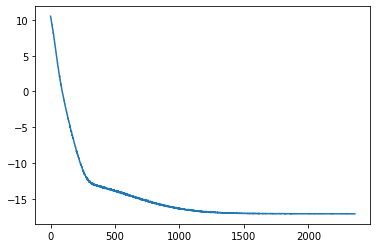

In [625]:
plt.plot(samples_kls)
plt.show()

In [626]:
with torch.no_grad():
    z_K = q.sample(n=100000)
    z_K = z_K.detach().numpy()

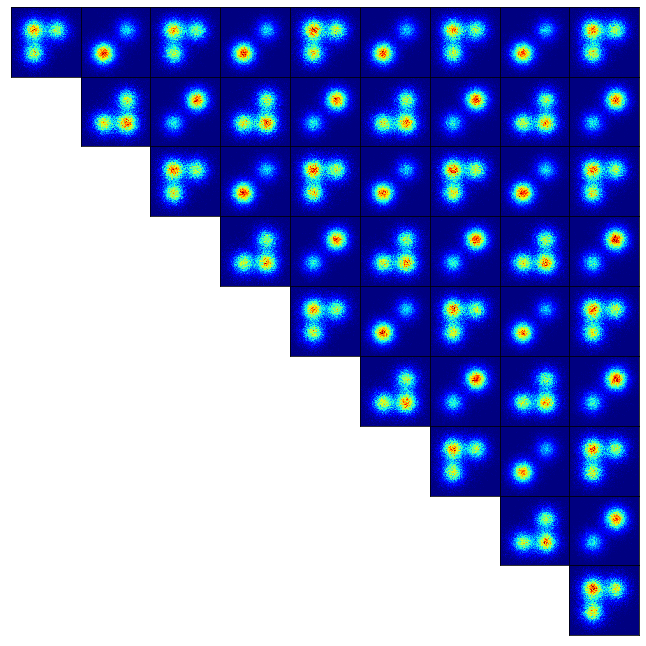

In [627]:
fig = plt.figure(figsize=(10, 10), )
for i in range(1, 10+1):
    for j in range(1, 10+1):
        if i < j:
            
            fig.add_subplot(10, 10, (i-1) * 10 + j)
            
            plt.hist2d(z_K[:,i-1], z_K[:,j-1], bins=100, cmap="jet", range=[[-15, 15], [-15, 15]])
            
            plt.xlim(-15, 15)
            plt.ylim(-15, 15)
            plt.xticks([])
            plt.yticks([])
            plt.gca().set_aspect("equal")
        
plt.tight_layout() 
fig.subplots_adjust(wspace=0, hspace=0)
        
plt.savefig("10d_trimodal_learned_density.png", dpi=100, bbox_inches='tight')